# readme
descrip: plot Boston, New York SSH, steric height and AMOC Time Series for Sunway TR (transient) runs <br>

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
 
extra notes: <br>
I used xoak to select cities from POP grids following https://pop-tools.readthedocs.io/en/latest/examples/xoak-example.html <br>
There is memory issue if use large data set files with xoak. I first use xoak with t12 and g16 grid files to get index for cities then select index for large data set files. 

# import modules

In [1]:
# general python packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import cartopy
# import cartopy.crs as ccrs
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# python GCM(POP) packages
import xgcm
import pop_tools
import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.1.163:41041")
client

Client Scheduler: tcp://10.73.1.163:41041 Dashboard: http://10.73.1.163:8787/status,Cluster Workers: 10 Cores: 10 Memory: 210.00 GB


# define parameters

In [3]:
chunks_HR = {'nlat':400,'nlon':300}
chunks_LR = {'nlat':384,'nlon':320}

# === AMOC files ===
# --- TH (transient HR) ---
infile_MOC_TH = ('/scratch/group/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
# -------------------------

# --- TL (transient LR) ---
infile_MOC_TL = ('/scratch/group/ihesp/archive/Sunway_Runs/'
'LR_HF_TNST/B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
# -------------------------
# ==================

# === POP grids files ===
infile0_g16 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
infile0_t12 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# =======================

outdir='/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'SSHAMOCStericHeightTimeSeriesSunwayTR_2021May20.png'

# read data files
read MOC files

In [4]:
ds_MOC_TL = xr.open_dataset(infile_MOC_TL)
time_s_TL = ds_MOC_TL.time.to_pandas().index.shift(-1,'M')  # convert FOSI time (model year) to actual year
ds_MOC_TL = ds_MOC_TL.assign_coords(time=time_s_TL)
ds_MOC_TL

<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [5]:
ds_MOC_TH = xr.open_dataset(infile_MOC_TH)
time_s_TH = ds_MOC_TH.time.to_pandas().index.shift(-1,'M') # shift 1 mon
ds_MOC_TH = ds_MOC_TH.assign_coords(time=time_s_TH)
ds_MOC_TH

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

read SSH files

In [6]:
infile1_ssh_TH = ('/scratch/group/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
              'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TH = xr.open_dataset(infile1_ssh_TH, chunks=chunks_HR)

infile1_ssh_TL = ('/scratch/group/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
              'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TL = xr.open_dataset(infile1_ssh_TL,chunks=chunks_LR)
ds_ssh_TL

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 3012)
Coordinates:
  * time        (time) object 1850-01-17 12:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(3012, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(3012, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

read steric height

In [7]:
infile_h_rst_TH = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway_RegionalStericHeight1850-2100_2021May21.nc')
# infiles_TH
ds_h_rst_TH = xr.open_dataset(infile_h_rst_TH, chunks=chunks_HR)
ds_h_rst_TH

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 251)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(251, 400, 300), meta=np.ndarray>

In [8]:
infile_h_rst_CH = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_RegionalStericHeight250-500_2021May21.nc')
# infiles_TH
ds_h_rst_CH = xr.open_dataset(infile_h_rst_CH, chunks=chunks_HR)
ds_h_rst_CH

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 251)
Coordinates:
  * time     (time) object 0250-12-31 00:00:00 ... 0500-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(251, 400, 300), meta=np.ndarray>

transient LR (TL)

In [9]:
infile_h_rst_TL = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway_RegionalStericHeight1850-2100_2021May21.nc')
ds_h_rst_TL = xr.open_dataset(infile_h_rst_TL, chunks=chunks_LR)
ds_h_rst_TL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 250)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(250, 384, 320), meta=np.ndarray>

In [10]:
infile_h_rst_CL = ('/scratch/user/dapengli/Projects4iHESP/'
'Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/'
'RegionalStericHeight/test_2021Apr20/'
'B.E.13.B1850C5.ne30g16.sehires38.003.sunway_RegionalStericHeight250-500_2021May21.nc')
ds_h_rst_CL = xr.open_dataset(infile_h_rst_CL, chunks=chunks_LR)
ds_h_rst_CL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 246)
Coordinates:
  * time     (time) object 0250-12-31 00:00:00 ... 0500-12-31 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    h_rst    (time, nlat, nlon) float64 dask.array<chunksize=(246, 384, 320), meta=np.ndarray>

read grid files

In [11]:
ds0_g16 = xr.open_dataset(infile0_g16)
ds0_t12 = xr.open_dataset(infile0_t12)

In [12]:
grid_t12, xds_t12 = pop_tools.to_xgcm_grid_dataset(ds0_t12)
grid_g16, xds_g16 = pop_tools.to_xgcm_grid_dataset(ds0_g16)

_, xds_ssh_TH = pop_tools.to_xgcm_grid_dataset(ds_ssh_TH)
# _, xds_ssh_CH = pop_tools.to_xgcm_grid_dataset(ds_ssh_CH)
_, xds_ssh_TL = pop_tools.to_xgcm_grid_dataset(ds_ssh_TL)
# _, xds_ssh_CL = pop_tools.to_xgcm_grid_dataset(ds_ssh_CL)

ds_h_rst_TH.h_rst.attrs['grid_loc']=2110 # add grid loc for xgcm to recognize tgrids
# ds_h_st_CH.h_rst.attrs['grid_loc']=2110 # add grid loc for xgcm to recognize tgrids
ds_h_rst_TL.h_rst.attrs['grid_loc']=2110 # add grid loc for xgcm to recognize tgrids
# ds_h_st_CL.h_rst.attrs['grid_loc']=2110 # add grid loc for xgcm to recognize tgrids

_, xds_h_rst_TH = pop_tools.to_xgcm_grid_dataset(ds_h_rst_TH)
# _, xds_h_st_CH = pop_tools.to_xgcm_grid_dataset(ds_h_st_CH)
_, xds_h_rst_TL = pop_tools.to_xgcm_grid_dataset(ds_h_rst_TL)
# _, xds_h_st_CL = pop_tools.to_xgcm_grid_dataset(ds_h_st_CL)

In [13]:
xds_t12.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')
xds_g16.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')

In [14]:
# Boston (71.1W, 42.4N), New york (74.0W, 40.7N), 
# I adjust lat and lon a little because the original lat lon are on land (KMT=0)
# cities_t12 = xds_t12.xoak.sel(
#     TLONG=xr.Variable("cities", [-69.9+360, -74+360]),
#     TLAT=xr.Variable("cities", [42, 40.5]))
cities_t12 = xds_t12.xoak.sel(
    TLONG=xr.Variable("cities", [-70.5+360, -74+360]),
    TLAT=xr.Variable("cities", [42.0, 40.5]))
cities_t12

<xarray.Dataset>
Dimensions:      (cities: 2, nlat_u: 2400, nlon_u: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
    TLAT         (cities) float64 42.0 40.5
    TLONG        (cities) float64 289.5 286.0
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
  * nlon_u       (nlon_u) int64 1 2 3 4 5 6 7 ... 3595 3596 3597 3598 3599 3600
  * nlat_u       (nlat_u) int64 1 2 3 4 5 6 7 ... 2395 2396 2397 2398 2399 2400
    nlon_t       (cities) float64 403.5 366.5
    nlat_t       (cities) float64 1.65e+03 1.634e+03
Dimensions without coordinates: cities
Data variables:
    ULAT         (nlat_u, nlon_u) float64 -78.45 -78.45 -78.45 ... 62.34 62.34
    ULONG        (nlat_u, nlon_u) float64 -109.9 -109.8 -109.7 ... -110.0 -110.0
    DXT          (cities) float64 8.265e+05 8.43e+05
    DYT          (cities) float64 8.039e+05 8.016e+05
    TAREA        (cities) float64 6.644e+11 6.757e+11
    KMT          (cities) int32 3 3
    REGION_MASK  (cities) int32 6 6
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:       [2400 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v2/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v2/grid/topography_km62_201711...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v2/grid/region_mask_20080702.i...
    type:               tripole
    title:              POP_tx0.1v2 grid

In [15]:
# Boston (71.1W, 42.4N), New york (74.0W, 40.7N), 
# I adjust lat and lon a little because the original lat lon are on land (KMT=0)
cities_g16 = xds_g16.xoak.sel(
    TLONG=xr.Variable("cities", [-70.5+360, -74+360]),
    TLAT=xr.Variable("cities", [42.0, 40.5]))
cities_g16

<xarray.Dataset>
Dimensions:      (cities: 2, nlat_u: 384, nlon_u: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
    TLAT         (cities) float64 41.93 40.33
    TLONG        (cities) float64 289.9 286.4
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nlon_u       (nlon_u) int64 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * nlat_u       (nlat_u) int64 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
    nlon_t       (cities) float64 292.5 289.5
    nlat_t       (cities) float64 305.5 301.5
Dimensions without coordinates: cities
Data variables:
    ULAT         (nlat_u, nlon_u) float64 -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG        (nlat_u, nlon_u) float64 321.1 322.3 323.4 ... 319.6 320.0
    DXT          (cities) float64 9.084e+06 9.35e+06
    DYT          (cities) float64 4.826e+06 4.917e+06
    TAREA        (cities) float64 4.383e+13 4.598e+13
    KMT          (cities) int32 6 3
    REGION_MASK  (cities) int32 6 6
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:         [384 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

In [16]:
print('real lon and lat for Boston and New York')
print([-71.1+360, 42.4])
print([-74.0+360, 40.7])

ssh_TH=xds_ssh_TH.sel(nlon_t=cities_t12.nlon_t.values,nlat_t=cities_t12.nlat_t.values).SSH
print('lon and lat on t12 grid')
print(ssh_TH.isel(nlon_t=0,nlat_t=0).TLONG.values,ssh_TH.isel(nlon_t=0,nlat_t=0).TLAT.values)
print(ssh_TH.isel(nlon_t=1,nlat_t=1).TLONG.values,ssh_TH.isel(nlon_t=1,nlat_t=1).TLAT.values)

ssh_TL=xds_ssh_TL.sel(nlon_t=cities_g16.nlon_t.values,nlat_t=cities_g16.nlat_t.values).SSH
print('lon and lat on g16 grid')
print(ssh_TL.isel(nlon_t=0,nlat_t=0).TLONG.values,ssh_TL.isel(nlon_t=0,nlat_t=0).TLAT.values)
print(ssh_TL.isel(nlon_t=1,nlat_t=1).TLONG.values,ssh_TL.isel(nlon_t=1,nlat_t=1).TLAT.values)

h_rst_TH=xds_h_rst_TH.sel(nlon_t=cities_t12.nlon_t.values,
                    nlat_t=cities_t12.nlat_t.values).h_rst
h_rst_TL=xds_h_rst_TL.sel(nlon_t=cities_g16.nlon_t.values,
                    nlat_t=cities_g16.nlat_t.values).h_rst

ssh_TH

real lon and lat for Boston and New York
[288.9, 42.4]
[286.0, 40.7]
lon and lat on t12 grid
289.4927248651452 42.000363243223966
285.9800385551817 40.5009890332746
lon and lat on g16 grid
289.87680609401775 41.92955449401052
286.4429434610795 40.32675645820816


<xarray.DataArray 'SSH' (time: 3012, nlat_t: 2, nlon_t: 2)>
dask.array<getitem, shape=(3012, 2, 2), dtype=float32, chunksize=(3012, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2100-12-17 00:00:00
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
  * nlon_t   (nlon_t) float64 403.5 366.5
  * nlat_t   (nlat_t) float64 1.65e+03 1.634e+03
Attributes:
    long_name:     Sea Surface Height
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

In [17]:
ssh_yr_TH = ssh_TH.resample(time='A').mean('time')
ssh_yr_TL = ssh_TL.resample(time='A').mean('time')
ssh_yr_TH

<xarray.DataArray 'SSH' (time: 251, nlat_t: 2, nlon_t: 2)>
dask.array<stack, shape=(251, 2, 2), dtype=float32, chunksize=(1, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
  * nlon_t   (nlon_t) float64 403.5 366.5
  * nlat_t   (nlat_t) float64 1.65e+03 1.634e+03

# make pics

In [18]:
MOC45_yr_TL = (ds_MOC_TL.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1).resample(time='A').mean('time'))
MOC45_yr_TH = (ds_MOC_TH.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1).resample(time='A').mean('time'))
MOC45_yr_TH

<xarray.DataArray 'MOC' (time: 251)>
array([15.120004 , 16.444918 , 17.04949  , 18.745255 , 18.02128  ,
       17.472525 , 19.309134 , 19.298847 , 16.547194 , 16.44132  ,
       17.866838 , 18.447832 , 18.24583  , 18.666765 , 19.489471 ,
       19.552494 , 18.886652 , 19.064049 , 20.06567  , 17.005636 ,
       18.355825 , 17.033075 , 15.549595 , 17.188482 , 17.022575 ,
       16.267538 , 15.423226 , 14.98082  , 16.338614 , 16.746784 ,
       16.724062 , 16.204107 , 17.77412  , 17.159117 , 17.709124 ,
       17.061163 , 16.997816 , 17.2236   , 17.453753 , 16.159822 ,
       18.948645 , 17.954468 , 18.067192 , 16.329098 , 16.063047 ,
       18.57193  , 17.360264 , 16.450151 , 15.205365 , 14.858092 ,
       16.542517 , 17.500652 , 18.101244 , 18.862825 , 19.317232 ,
       18.80632  , 18.272478 , 16.68756  , 18.833189 , 18.491484 ,
       16.604101 , 17.218168 , 15.859653 , 16.82247  , 14.904725 ,
       15.893887 , 17.2852   , 18.015795 , 16.249424 , 16.856848 ,
       14.396205 , 15.207012 , 17.637775 , 16.33367  , 14.221154 ,
       15.831758 , 15.293419 , 16.43131  , 16.830643 , 16.169401 ,
       16.950922 , 18.741636 , 15.779613 , 16.471302 , 16.107237 ,
       17.709185 , 19.629225 , 18.164423 , 16.942123 , 16.642088 ,
       19.177687 , 18.089403 , 17.240276 , 16.964226 , 16.677599 ,
       16.16825  , 15.707332 , 15.487254 , 15.890788 , 15.181844 ,
...
       16.957977 , 16.74568  , 16.416965 , 16.075766 , 17.299227 ,
       16.092182 , 16.73659  , 16.327955 , 16.596039 , 16.596071 ,
       14.964383 , 16.152273 , 15.720402 , 17.338995 , 16.311857 ,
       15.356696 , 14.643234 , 15.046252 , 14.98606  , 16.172945 ,
       16.442118 , 14.941468 , 14.686905 , 14.813628 , 12.498653 ,
       14.92043  , 15.647316 , 15.883114 , 16.8997   , 15.066585 ,
       16.16576  , 13.644112 , 14.594521 , 14.220506 , 13.649962 ,
       15.2827635, 12.606927 , 13.637975 , 12.573555 , 13.209984 ,
       14.42694  , 13.5409155, 14.508102 , 13.067329 , 13.729637 ,
       13.38221  , 14.207676 , 14.7184515, 14.494476 , 13.966252 ,
       13.6609335, 14.633298 , 12.829087 , 12.182702 , 12.118396 ,
       12.568867 , 13.099486 , 12.045475 , 11.895144 , 12.668895 ,
       14.085106 , 13.594117 , 13.243449 , 12.917737 , 11.162582 ,
       12.826046 , 11.664776 , 10.890426 , 10.397122 , 11.11139  ,
       11.858224 , 11.471057 , 12.16995  , 12.725026 , 11.236511 ,
       11.698628 , 11.909004 , 10.953728 , 11.494975 , 10.774434 ,
       10.411097 , 10.7522745, 10.278907 ,  9.243911 ,  9.131544 ,
       11.00893  , 10.387916 ,  9.752358 ,  9.703551 ,  9.887286 ,
       10.637841 ,  9.851748 ,  7.3754783, 10.189496 ,  9.702498 ,
        9.248578 ], dtype=float32)
Coordinates:
  * time               (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 44.76

In [19]:
# MOC45_yr_CL = (ds_MOC_CL.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
#     moc_comp=0, transport_reg=1).resample(time='A').mean('time')).isel(time=slice(249,500))
# MOC45_yr_CH = (ds_MOC_CH.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
#     moc_comp=0, transport_reg=1).resample(time='A').mean('time')).isel(time=slice(229,480))
# MOC45_yr_CH

In [20]:
ssh_yr_TH = ssh_yr_TH.compute()
# ssh_yr_CH = ssh_yr_CH.compute()
ssh_yr_TL = ssh_yr_TL.compute()
# ssh_yr_CL = ssh_yr_CL.compute()

# LR has a negative SSH bias, so I compute anomaly relative to 1850-2950 mean to remove bias
ssh_yra_TH = ssh_yr_TH-ssh_yr_TH.sel(time=slice('1850','1950')).mean('time')
# ssh_yra_CH = ssh_yr_CH-ssh_yr_CH.sel(time=slice('1850','1950')).mean('time')
ssh_yra_TL = ssh_yr_TL-ssh_yr_TL.sel(time=slice('1850','1950')).mean('time')
# ssh_yra_CL = ssh_yr_CL-ssh_yr_CL.sel(time=slice('1850','1950')).mean('time')

# ssh_yra_TH = ssh_yr_TH-ssh_yr_TH.isel(time=0)
# ssh_yra_CH = ssh_yr_CH-ssh_yr_CH.isel(time=0)
# ssh_yra_TL = ssh_yr_TL-ssh_yr_TL.isel(time=0)
# ssh_yra_CL = ssh_yr_CL-ssh_yr_CL.isel(time=0)

# I compute anomaly relative to 1850-1950 since we are interested in the relative change
h_rst_a_TH = h_rst_TH - h_rst_TH.sel(time=slice('1850','1950')).mean('time')
# h_rst_a_CH = h_rst_CH - h_rst_CH.isel(time=slice(0,101)).mean('time')
h_rst_a_TL = h_rst_TL - h_rst_TL.sel(time=slice('1850','1950')).mean('time')
# h_rst_a_CL = h_rst_CL - h_rst_CL.isel(time=slice(0,101)).mean('time')

In [21]:
h_rst_gl_av_TH = ds_h_rst_TH.h_rst.weighted(ds0_t12.TAREA).mean(("nlon", "nlat")).compute()
# interpolate_na has trouble with dask array, so I use .compute to make it xarray
h_rst_gl_av_CH = ds_h_rst_CH.h_rst.weighted(ds0_t12.TAREA).mean(("nlon", "nlat")).compute()
h_rst_gl_av_TL = ds_h_rst_TL.h_rst.weighted(ds0_g16.TAREA).mean(("nlon", "nlat")).compute()
h_rst_gl_av_CL = ds_h_rst_CL.h_rst.weighted(ds0_g16.TAREA).mean(("nlon", "nlat")).compute()

h_rst_gl_a_TH = h_rst_gl_av_TH - h_rst_gl_av_TH.isel(time=0) # a: anomaly
h_rst_gl_a_TH = h_rst_gl_a_TH.where(h_rst_gl_a_TH<50, np.nan) # mask spikes as nan
h_rst_gl_a_fn_TH = h_rst_gl_a_TH.interpolate_na(dim="time", method="linear") # fn: fill nan
# fill nan with linear interpolation 
h_rst_gl_a_CH = h_rst_gl_av_CH - h_rst_gl_av_CH.isel(time=0)
h_rst_gl_a_TL = h_rst_gl_av_TL - h_rst_gl_av_TL.isel(time=0) # a: anomaly
h_rst_gl_a_CL = h_rst_gl_av_CL - h_rst_gl_av_CL.isel(time=0) # a: anomaly

In [22]:
# interpolation
yrs = np.arange(1850,2100+1,1)
yrs_TL = np.arange(1850,2100+1,1)
yrs_TL = yrs_TL[yrs_TL != 2014] # TL miss 2014Jan, so no yr-av for 2014
yrs_CL_raw = np.arange(250,500+1)
yrs_CL = np.delete(yrs_CL_raw,[374-250, 398-250, 401-250, 417-250, 445-250])
# yr: 374, 398, 401, 417, 445 have missing monthly data files, do not use them

h_rst_gl_a_intp_TL = np.interp(np.arange(1850,2100+1,1),yrs_TL,h_rst_gl_a_TL.values)
h_rst_gl_a_intp_CL = np.interp(yrs_CL_raw,yrs_CL,h_rst_gl_a_CL.values)

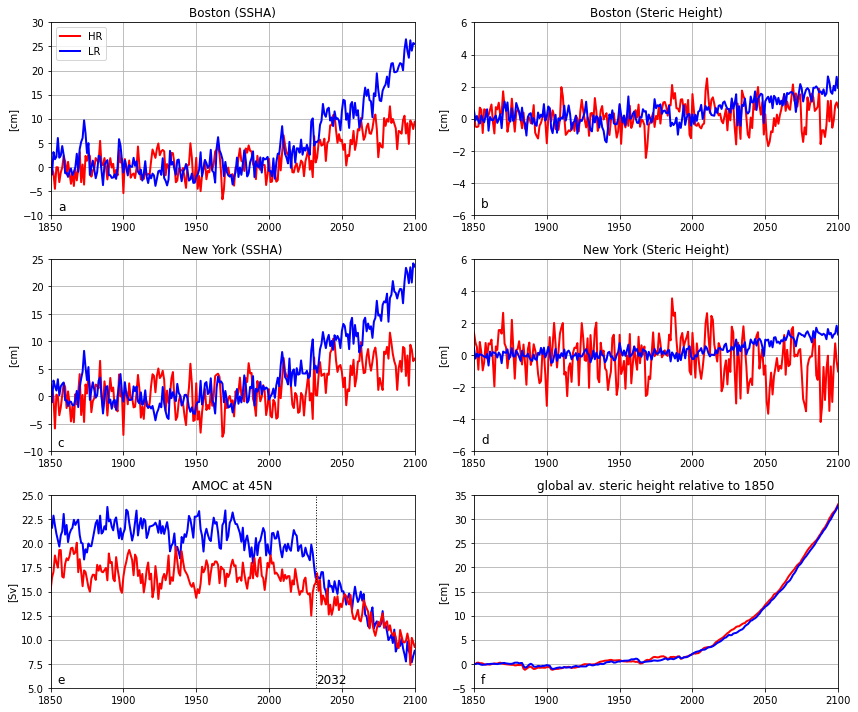

In [23]:
fig1, axs = plt.subplots(3,2,figsize=(12, 10))

# row 1: Boston
axs[0,0].plot(yrs, ssh_yra_TH.isel(nlon_t=0,nlat_t=0), color='r', 
            linewidth=2, label="HR")
axs[0,0].plot(yrs, ssh_yra_TL.isel(nlon_t=0,nlat_t=0), color='b', 
            linewidth=2, label="LR")
axs[0,0].set_xlim([1850,2100])
axs[0,0].set_ylim([-10,30])
# axs[0,0].set_xticks(np.arange(1850, 2100+1,50))
# axs[0,0].set_xticklabels(np.arange(1850, 2100+1,50), fontsize=12)
# axs[0,0].set_yticks(np.arange(-10, 30+1,5))
# axs[0,0].set_yticklabels(np.arange(-10, 30+1,5), fontsize=12)
axs[0,0].grid()
axs[0,0].set_ylabel('[cm]')
axs[0,0].set_title('Boston (SSHA)', fontsize=12)
axs[0,0].text(1855, -9, 'a', fontsize=12)
axs[0,0].legend()

axs[0,1].plot(yrs, h_rst_a_TH.isel(nlon_t=0,nlat_t=0), color='r', 
            linewidth=2, label="HR")
axs[0,1].plot(yrs_TL, h_rst_a_TL.isel(nlon_t=0,nlat_t=0), color='b', 
            linewidth=2, label="LR")
axs[0,1].set_xlim([1850,2100])
axs[0,1].set_ylim([-6,6])
axs[0,1].grid()
axs[0,1].set_ylabel('[cm]')
axs[0,1].set_title('Boston (Steric Height)', fontsize=12)
axs[0,1].text(1855, -5.5, 'b', fontsize=12)


# row 2: New Yok 
axs[1,0].plot(yrs, ssh_yra_TH.isel(nlon_t=1,nlat_t=1), color='r', 
            linewidth=2, label="HR")
axs[1,0].plot(yrs, ssh_yra_TL.isel(nlon_t=1,nlat_t=1), color='b', 
            linewidth=2, label="LR")
axs[1,0].set_xlim([1850,2100])
axs[1,0].set_ylim([-10,25])
axs[1,0].set_ylabel('[cm]')
axs[1,0].set_title('New York (SSHA)', fontsize=12)
axs[1,0].grid()
axs[1,0].text(1855, -9, 'c', fontsize=12)

axs[1,1].plot(yrs, h_rst_a_TH.isel(nlon_t=1,nlat_t=1), color='r', 
            linewidth=2, label="HR")
axs[1,1].plot(yrs_TL, h_rst_a_TL.isel(nlon_t=1,nlat_t=1), color='b', 
            linewidth=2, label="LR")
axs[1,1].set_xlim([1850,2100])
axs[1,1].set_ylim([-6,6])
axs[1,1].grid()
axs[1,1].set_ylabel('[cm]')
axs[1,1].set_title('New York (Steric Height)', fontsize=12)
axs[1,1].text(1855, -5.5, 'd', fontsize=12)

# row 3: MOC
axs[2,0].plot(yrs, MOC45_yr_TL, color='b', linewidth=2, label="TR LR")
axs[2,0].plot(yrs, MOC45_yr_TH, color='r', linewidth=2, label="TR HR")
axs[2,0].plot([2032,2032], [5,25], color='k',linestyle=':', linewidth=1)
axs[2,0].text(2032, 5.5, '2032', fontsize=12)
axs[2,0].set_xlim([1850,2100])
axs[2,0].set_ylim([5,25])
axs[2,0].set_ylabel('[Sv]')
axs[2,0].set_title('AMOC at 45N', fontsize=12)
axs[2,0].grid()
axs[2,0].text(1855, 5.5, 'e', fontsize=12)


axs[2,1].plot(np.arange(1850,2100+1,1), (h_rst_gl_a_fn_TH.values-h_rst_gl_a_CH.values), 
         color='r', linewidth=2, label='TR-CN (HR)')
axs[2,1].plot(np.arange(1850,2100+1,1), (h_rst_gl_a_intp_TL-h_rst_gl_a_intp_CL), 
         color='b', linewidth=2, label='TR-CN (LR)')
axs[2,1].set_xlim([1850,2100])
axs[2,1].set_ylim([-5,35])
axs[2,1].set_ylabel('[cm]')
axs[2,1].set_title('global av. steric height relative to 1850', fontsize=12)
axs[2,1].grid()
axs[2,1].text(1855, -4, 'f', fontsize=12)

fig1.tight_layout()

fig1.savefig(pic1,bbox_inches='tight')

# Appendix 
plot original SSH 

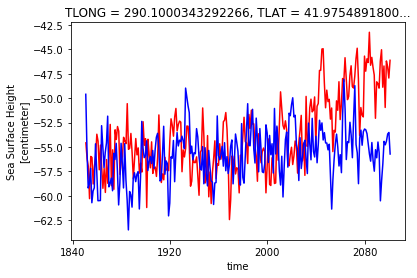

In [23]:
ssh_yr_TH.isel(nlon_t=0,nlat_t=0).plot(color='r')
ssh_yr_CH.isel(nlon_t=0,nlat_t=0).plot(color='b')

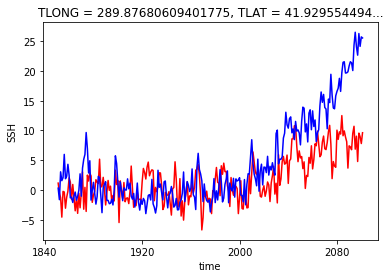

In [24]:
(ssh_yr_TH.isel(nlon_t=0,nlat_t=0) - 
 ssh_yr_TH.isel(nlon_t=0,nlat_t=0).sel(time=slice('1850','1950')).mean('time')).plot(color='r')
(ssh_yr_TL.isel(nlon_t=0,nlat_t=0) - 
ssh_yr_TL.isel(nlon_t=0,nlat_t=0).sel(time=slice('1850','1950')).mean('time')).plot(color='b')

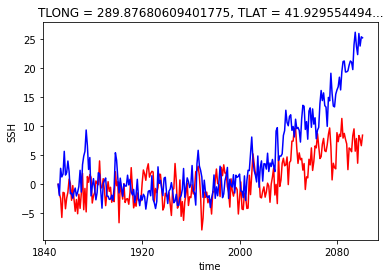

In [25]:
(ssh_yr_TH.isel(nlon_t=0,nlat_t=0) - 
 ssh_yr_TH.isel(nlon_t=0,nlat_t=0).isel(time=0)).plot(color='r')
(ssh_yr_TL.isel(nlon_t=0,nlat_t=0) - 
ssh_yr_TL.isel(nlon_t=0,nlat_t=0).isel(time=0)).plot(color='b')

check MOC coordinates 

In [26]:
ds_MOC_TH.MOC

<xarray.DataArray 'MOC' (time: 3012, transport_reg: 2, moc_comp: 1, moc_z: 63, lat_aux_grid: 395)>
[149907240 values with dtype=float32]
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
    moc_components     (moc_comp) |S256 b'Eulerian Mean'
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg, moc_comp
Attributes:
    units:      Sverdrups
    long_name:  Meridional Overturning Circulation

In [27]:
ds_MOC_TH.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
             method='nearest').sel(moc_comp=0, transport_reg=1)

<xarray.DataArray 'MOC' (time: 3012)>
array([11.917703, 15.644326, 16.27959 , ...,  9.647427, 11.984182,  8.552816],
      dtype=float32)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 44.76
Attributes:
    units:      Sverdrups
    long_name:  Meridional Overturning Circulation